<a href="https://colab.research.google.com/github/mgKim7/DAP__/blob/main/%EB%8D%B0%EB%B6%84%ED%94%84_%EA%B3%BC%EC%A0%9C_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 불러오기

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV      

def null_remover_by_hour(column, data):
    for i in data[data[column].isna()].index:
        data[column].fillna({i: train_backup.groupby('hour').mean()[column][data['hour'][i]]}, inplace=True)


데이터 불러오기

In [64]:
from google.colab import drive

drive.mount('/content/gdrive')

import os
print(os.listdir('/content/gdrive/My Drive/데분프/데분프 과제 final/'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['데분프 과제 final.ipynb', 'test.csv', 'train.csv', 'submission.csv']


In [65]:
train_data = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/test.csv')
submission = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/submission.csv')
train_backup = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/train.csv')
test_backup = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/test.csv')



* id : 날짜와 시간별 id
* hour_bef_temperature : 1시간 전 기온
* hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가오면 1
* hour_bef_windspeed : 1시간 전 풍속(평균)
* hour_bef_humidity : 1시간 전 습도
* hour_bef_visibility :1시간 전 특정 기상 상태에 따른 가시성
* hour_bef_ozone : 1시간 전 오존
* hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5 ~ 1/7 크기)	
* hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20 ~ 1/30 크기)
* count : 시간에 따른 따릉이 대여 수

In [67]:
train_data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [68]:
#test데이터는 열이 한개 부족한데 예측해야하는 count열이 없기 때문에 train데이터에 비해 열이 한개 부족
#count는 test데이터를 바탕으로 대여량이 얼마인지 예측해야 하기 때문에 count 열이 없음

print(train_data.shape)
print(test_data.shape)
print(submission.shape)

(1459, 11)
(715, 10)
(715, 2)


In [69]:
#결측값 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [70]:
test_data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [71]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [72]:
submission.head()

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


각 데이터 기술 통계량 확인

In [73]:
train_data.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [75]:
test_data.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


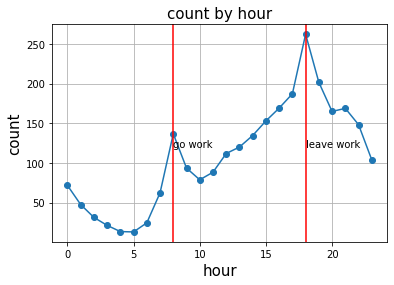

In [79]:
plt.plot(train_data.groupby('hour').mean()['count'], 'o-')
plt.grid()

plt.title('count by hour', fontsize = 15)
plt.xlabel('hour', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.axvline(8, color='r')
plt.axvline(18, color='r')
plt.text(8, 120, 'go work', fontsize = 10)
plt.text(18, 120, 'leave work', fontsize = 10)

plt.show()


상관관계 확인

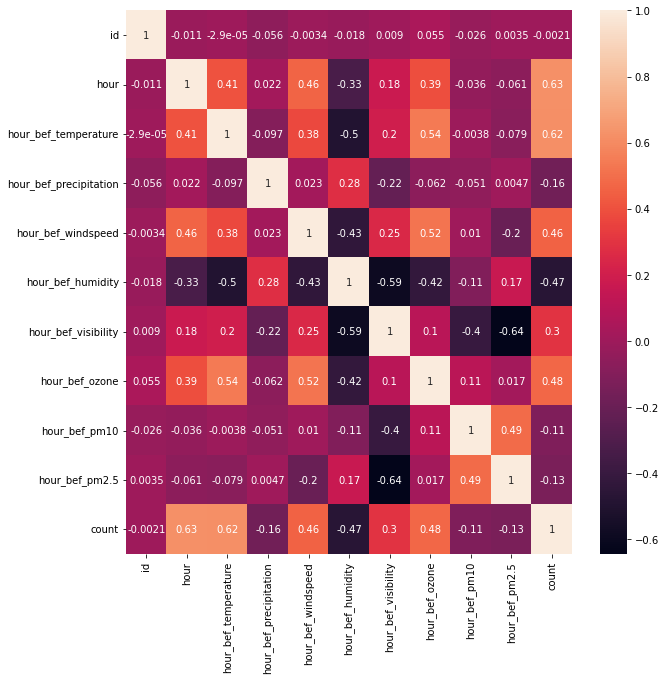

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      2
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         2
hour_bef_ozone              0
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64


In [18]:
#찾을 것이 count이기 때문에 count와 상관계수 높은 변수 찾기 hour, hour_bef_temperature, hour_bef_windspeed
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True)
plt.show()

null_remover_by_hour('hour_bef_temperature', train_data)
null_remover_by_hour('hour_bef_windspeed', train_data)
null_remover_by_hour('hour_bef_temperature', test_data)
null_remover_by_hour('hour_bef_windspeed', test_data)
null_remover_by_hour('hour_bef_humidity', train_data)
null_remover_by_hour('hour_bef_humidity', test_data)
train_data['hour_bef_ozone'].fillna(0.0321275, inplace=True)
print(train_data.isna().sum())